In [1]:
def classwise_ece(y_true, y_prob, n_bins=10):
    n_classes = y_true.shape[1]
    ece = 0.0
    for c in range(n_classes):
        y_class = y_true[:, c]
        y_prob_class = y_prob[:, c]
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob_class, bins) - 1
        bin_sizes = np.bincount(bin_indices, minlength=n_bins)
        bin_probs = np.bincount(bin_indices, weights=y_prob_class, minlength=n_bins) / (bin_sizes + 1e-10)
        bin_accuracies = np.bincount(bin_indices, weights=y_class, minlength=n_bins) / (bin_sizes + 1e-10)
        ece_class = np.abs(bin_accuracies - bin_probs).dot(bin_sizes / y_class.shape[0])
        ece += ece_class
    ece /= n_classes
    return ece

In [2]:
from scipy.stats import pearsonr

def pearson_correlation(y_pred_prob1, y_pred_prob2):
    n_classes = y_pred_prob1.shape[1]
    corrs = np.zeros(n_classes)
    for class_idx in range(n_classes):
        corrs[class_idx], _ = pearsonr(y_pred_prob1[:, class_idx], y_pred_prob2[:, class_idx])
    return corrs

In [3]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from tqdm import tqdm
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


TRAIN_SIZE = 2000
TEST_SIZE = 2000

mndata = MNIST('data')
images, labels = mndata.load_training()
images = np.array(images[:TRAIN_SIZE])
labels = np.array(labels[:TRAIN_SIZE])

test_images, test_labels = mndata.load_testing()
test_images = np.array(test_images[:TEST_SIZE])
test_labels = np.array(test_labels[:TEST_SIZE])

2023-02-17 18:10:25.286239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 18:10:25.407041: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 18:10:25.411865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 18:10:25.411886: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [4]:
def build_model(input_shape, activation, n_hiddenlayers, hidden_dim):
    input = Input(shape=(input_shape,))
    for i in range(n_hiddenlayers):
      if i == 0:
        x = Dense(hidden_dim, activation=activation)(input)
      else :
        x = Dense(hidden_dim, activation=activation)(x)
        x = Dropout(rate=0.2)(x)

      output = Dense(10, activation='softmax')(x)
      model = Model(input, output, name='first_model')
    return model

In [5]:
# Build a network with 10 hidden layers with 'tanh' activations
n_hiddenlayers = 10
activation = 'relu'
hidden_dim = 256
model = build_model(np.array(images).shape[1], activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()

2023-02-17 18:10:31.336723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-17 18:10:31.336763: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-17 18:10:31.336784: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-e76c8840-118e-4c48-bc4e-42f2efb5350a): /proc/driver/nvidia/version does not exist
2023-02-17 18:10:31.337090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "first_model"
___________________________________________

In [6]:
from sklearn.model_selection import train_test_split

checkpoint = ModelCheckpoint("models/weights.{epoch:02d}.hdf5", period=1, save_best_only=False, verbose=1)

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, 
            random_state=56)

# Configure the model and start training
# Stop training with early stopping with patience of 20
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=20)
callbacks_list = [checkpoint]

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(np.array(train_images), np.array(train_labels),validation_data=(val_images, val_labels),
                    epochs=100, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 5.7910 - accuracy: 0.1057
Epoch 1: saving model to models/weights.01.hdf5
8/8 [==============================] - 1s 75ms/step - loss: 5.7002 - accuracy: 0.1056 - val_loss: 2.3148 - val_accuracy: 0.0700
Epoch 2/100
7/8 [=========================>....] - ETA: 0s - loss: 2.3859 - accuracy: 0.1074
Epoch 2: saving model to models/weights.02.hdf5
8/8 [==============================] - 0s 47ms/step - loss: 2.3835 - accuracy: 0.1100 - val_loss: 2.2995 - val_accuracy: 0.1100
Epoch 3/100
6/8 [=====================>........] - ETA: 0s - loss: 2.3330 - accuracy: 0.1067
Epoch 3: saving model to models/weights.03.hdf5
8/8 [==============================] - 0s 47ms/step - loss: 2.3322 - accuracy: 0.1067 - val_loss: 2.2865 - val_accuracy: 0.1650
Epoch 4/100
7/8 [=========================>....] - ETA: 0s - loss: 2.2963 - accuracy: 0.1309
Epoch 4: saving model to models/weights.04.hdf5
8/8 [==============================] - 0s 43ms/step 

In [7]:
y_prob = model.predict(test_images)

63/63 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.93      0.98      0.96       175
           1       0.97      0.98      0.97       234
           2       0.91      0.86      0.89       219
           3       0.88      0.80      0.84       207
           4       0.90      0.88      0.89       217
           5       0.80      0.87      0.83       179
           6       0.89      0.84      0.87       178
           7       0.90      0.86      0.88       205
           8       0.78      0.81      0.80       192
           9       0.81      0.90      0.85       194

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



<AxesSubplot: >

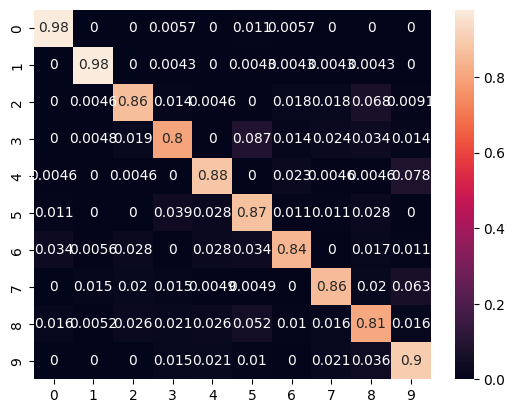

In [8]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print (classification_report(np.array(test_labels), np.argmax(y_prob, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob, axis=1), normalize="true"),annot=True)

In [9]:
ece_value = classwise_ece(np.eye(10)[test_labels], y_prob)
print("Expected Calibration Error:", ece_value)

Expected Calibration Error: 0.021923192544813296


In [10]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

In [11]:
import os

epochs = []
accuracy_values = []

for filename in os.listdir("models"):
    model_name = os.path.splitext(filename)[0]
    epoch = get_trailing_number(model_name)
    epochs.append(epoch)


    early_exit_model = load_model("models/" + filename)
    y_prob_early_exit = early_exit_model.predict(test_images, batch_size=32)
    accuracy = accuracy_score(np.array(test_labels), np.argmax(y_prob_early_exit, axis=1))
    accuracy_values.append(accuracy)

63/63 [==============================] - 0s 2ms/step


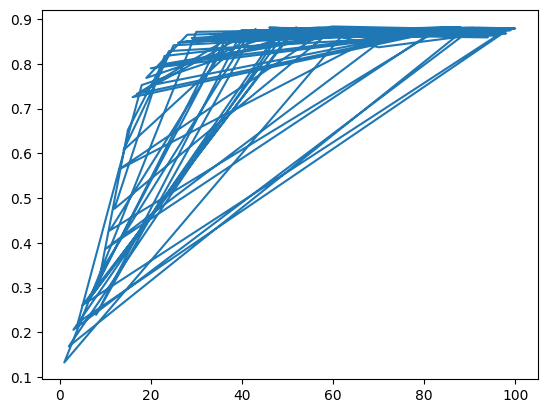

In [25]:
df = pd.DataFrame()
df["epoch"] = epochs
df["accuracy"] = accuracy_values

df.sort_values(by=["epoch"])


plt.plot(df["epoch"].to_numpy(), df["accuracy"].to_numpy())
# axis[1].plot(df["theta"], df["f1_score"])
plt.show()

In [16]:
df.shape

(100, 2)

In [14]:
!rm models/*

In [17]:
df["epoch"]

0     21
1     83
2     10
3     72
4     39
      ..
95     6
96    37
97    95
98    55
99    64
Name: epoch, Length: 100, dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e76c8840-118e-4c48-bc4e-42f2efb5350a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>